# Intermittent Math Modelling

This notebook focuses on mathematical modeling of intermittent treatment data for cancer cell growth dynamics.
Data is extracted from the organized processed datasets with exact seeding densities (20k and 30k).

In [87]:
# Essential packages for intermittent treatment modeling should only run once per project
using Pkg
Pkg.add("CSV")
Pkg.add("DataFrames")
Pkg.add("Plots")
Pkg.add("DifferentialEquations")
Pkg.add("Optimization")
Pkg.add("OptimizationOptimJL")
Pkg.add("OptimizationBBO")
Pkg.add("DiffEqParamEstim")
Pkg.add("StatsBase")
Pkg.add("SciMLSensitivity")
Pkg.add("BlackBoxOptim")
Pkg.add("StatsPlots")
Pkg.add("DataFramesMeta")
Pkg.add("Interact")
Pkg.add("Random")
Pkg.add("Distributions")

   Resolving package versions...
  No Changes to `C:\Users\MainFrameTower\.julia\environments\v1.11\Project.toml`
  No Changes to `C:\Users\MainFrameTower\.julia\environments\v1.11\Manifest.toml`
  No Changes to `C:\Users\MainFrameTower\.julia\environments\v1.11\Project.toml`
  No Changes to `C:\Users\MainFrameTower\.julia\environments\v1.11\Manifest.toml`
   Resolving package versions...
   Resolving package versions...
  No Changes to `C:\Users\MainFrameTower\.julia\environments\v1.11\Project.toml`
  No Changes to `C:\Users\MainFrameTower\.julia\environments\v1.11\Manifest.toml`
  No Changes to `C:\Users\MainFrameTower\.julia\environments\v1.11\Project.toml`
  No Changes to `C:\Users\MainFrameTower\.julia\environments\v1.11\Manifest.toml`
   Resolving package versions...
   Resolving package versions...
  No Changes to `C:\Users\MainFrameTower\.julia\environments\v1.11\Project.toml`
  No Changes to `C:\Users\MainFrameTower\.julia\environments\v1.11\Manifest.toml`
  No Changes to `C:\

In [88]:
using CSV
using DataFrames
using Plots
using DifferentialEquations
using Optimization, OptimizationOptimJL, OptimizationBBO
using BlackBoxOptim
using StatsBase
using Random
using Distributions
using Printf
using Statistics
using DiffEqParamEstim

In [ ]:
# Core modeling functions
function setUpProblem(modelTypeSet, xdataSet, ydataSet, solverSet, u0Set, pSet, tspanSet, boundsSet)
    best_params, best_sol, best_prob, best_loss = nothing, nothing, nothing, Inf

    for _ in 1:5
        p_init = [lo[1] == lo[2] ? lo[1] : rand(Uniform(lo[1], lo[2])) for lo in boundsSet]

        try
            prob = ODEProblem(modelTypeSet, u0Set, tspanSet, p_init)
            loss_func = build_loss_objective(prob, solverSet, L2Loss(xdataSet, ydataSet), Optimization.AutoForwardDiff())
            result = bboptimize(loss_func; SearchRange=boundsSet, MaxTime=30.0, TraceMode=:silent)
            p_opt = best_candidate(result)
            sol = solve(remake(prob, p=p_opt), solverSet, saveat=xdataSet)
            loss = sum(abs2.(ydataSet .- [u[1] for u in sol.u]))

            if loss < best_loss
                best_params, best_sol, best_prob, best_loss = p_opt, sol, prob, loss
            end
        catch; end
    end

    return best_params, best_sol, best_prob
end

function calculate_bic(probbic, xdatabic, ydatabic, solverbic, optparbic)
    # Ensure we evaluate the solution at the provided optimal parameters
    prob_eval = (optparbic === nothing) ? probbic : remake(probbic, p=optparbic)
    solbic = solve(prob_eval, solverbic, reltol=1e-15, abstol=1e-15, saveat=xdatabic)
    residualsbic = [ydatabic[i] - solbic(xdatabic[i])[1] for i in 1:length(xdatabic)]
    ssrbic = sum(residualsbic .^ 2)
    kbic = length(optparbic)
    nbic = length(xdatabic)
    bic = nbic * log(ssrbic / max(nbic, 1)) + kbic * log(max(nbic, 2))
    return bic, ssrbic
end

function plot_model_fit(x, y, optimized_params, optimized_sol, bic, ssr, title_str)
    println("\nOptimized Parameters: ", round.(optimized_params, digits=4))
    println("Sum of Squared Residuals (SSR): ", round(ssr, digits=6))
    println("Bayesian Information Criterion (BIC): ", round(bic, digits=2))
    
    p = plot(x, y, label="Data", legend=:bottomright, title=title_str, xlabel="Day", ylabel="Cell Count", 
             lw=2, marker=:circle, markersize=4)
    plot!(optimized_sol.t, [u[1] for u in optimized_sol.u], label="Model", lw=3, linestyle=:dash)
    
    display(p)
    return p
end

plot_model_fit (generic function with 1 method)

In [90]:
# Load intermittent data from processed datasets
function load_intermittent_data(seeding_density::String)
    base_path = "Processed_Datasets/Intermittent Data/$(seeding_density)_seeding_density/Averages/"
    
    # Define file mappings
    files = [
        "A2780T_dayaverages.csv",     # Naive treated
        "A2780UT_dayaverages.csv",    # Naive untreated  
        "A2780cisT_dayaverages.csv",  # Resistant treated
        "A2780cisUT_dayaverages.csv"  # Resistant untreated
    ]
    
    datasets = Dict{String, DataFrame}()
    
    for file in files
        try
            df = CSV.read(base_path * file, DataFrame)
            datasets[file] = df
            println("✅ Loaded: ", file, " ($(nrow(df)) rows)")
        catch e
            println("❌ Failed to load: $file")
            println("   ↳ Error: ", e)
        end
    end
    
    return datasets
end

# Extract x,y data from day averages CSV (data is already preprocessed)
function extract_xy_from_dayaverages(df::DataFrame)
    # Extract day and cell count data from preprocessed CSV
    x = Float64.(df[:, 1])  # First column (days)
    y = Float64.(df[:, 2])  # Second column (cell counts) - already processed
    
    println("   → Data range: Day $(x[1])-$(x[end]), Cell count $(minimum(y))-$(maximum(y))")
    return x, y
end

extract_xy_from_dayaverages (generic function with 1 method)

In [91]:
# Mathematical models for intermittent treatment

# 1. Standard logistic growth (for comparison)
function logistic_growth!(du, u, p, t)
    r, K = p
    du[1] = r * u[1] * (1 - u[1] / K)
end

# 2. Early treatment with lingering decay (T files: treated 0-7, untreated 7-14)
function early_treatment_decay!(du, u, p, t)
    r, K, drug_effect, decay_rate = p
    N = u[1]
    
    treatment_end = 7.0
    if t <= treatment_end
        # During treatment (days 0-7): full drug effect
        current_drug_effect = drug_effect
    else
        # Post-treatment (days 7-14): exponential decay of lingering effect
        time_since_treatment = t - treatment_end
        current_drug_effect = drug_effect * exp(-time_since_treatment / decay_rate)
    end
    
    effective_growth_rate = r * (1 - current_drug_effect)
    du[1] = effective_growth_rate * N * (1 - N / K)
end

# 3. Late treatment (UT files: untreated 0-7, treated 7-14)
function late_treatment!(du, u, p, t)
    r, K, drug_effect = p
    N = u[1]
    
    treatment_start = 7.0
    if t <= treatment_start
        # Pre-treatment (days 0-7): no drug effect
        current_drug_effect = 0.0
    else
        # During treatment (days 7-14): full drug effect
        current_drug_effect = drug_effect
    end
    
    effective_growth_rate = r * (1 - current_drug_effect)
    du[1] = effective_growth_rate * N * (1 - N / K)
end

# 4. Early treatment with biphasic decay (fast + slow clearance)
function early_treatment_biphasic!(du, u, p, t)
    r, K, drug_effect, fast_decay, slow_decay, fast_fraction = p
    N = u[1]
    
    treatment_end = 7.0
    if t <= treatment_end
        # During treatment: full effect
        current_drug_effect = drug_effect
    else
        # Post-treatment: biphasic decay
        time_since_end = t - treatment_end
        fast_component = fast_fraction * exp(-time_since_end / fast_decay)
        slow_component = (1 - fast_fraction) * exp(-time_since_end / slow_decay)
        current_drug_effect = drug_effect * (fast_component + slow_component)
    end
    
    effective_growth_rate = r * (1 - current_drug_effect)
    du[1] = effective_growth_rate * N * (1 - N / K)
end

# 5. Early treatment with power law decay (very persistent effects)
function early_treatment_powerlaw!(du, u, p, t)
    r, K, drug_effect, decay_exponent, time_scale = p
    N = u[1]
    
    treatment_end = 7.0
    if t <= treatment_end
        # During treatment: full effect
        current_drug_effect = drug_effect
    else
        # Post-treatment: power law decay
        time_since_end = t - treatment_end
        current_drug_effect = drug_effect / (1 + (time_since_end / time_scale)^decay_exponent)
    end
    
    effective_growth_rate = r * (1 - current_drug_effect)
    du[1] = effective_growth_rate * N * (1 - N / K)
end

# 6. Late treatment with immediate effect buildup
function late_treatment_buildup!(du, u, p, t)
    r, K, drug_effect, buildup_rate = p
    N = u[1]
    
    treatment_start = 7.0
    if t <= treatment_start
        # Pre-treatment: no effect
        current_drug_effect = 0.0
    else
        # During treatment: gradual buildup to full effect
        time_in_treatment = t - treatment_start
        current_drug_effect = drug_effect * (1 - exp(-time_in_treatment / buildup_rate))
    end
    
    effective_growth_rate = r * (1 - current_drug_effect)
    du[1] = effective_growth_rate * N * (1 - N / K)
end

# 7. Early treatment with Hill effect (T files: treated 0-7, untreated 7-14)
function early_treatment_hill!(du, u, p, t)
    r, K, max_drug_effect, hill_coeff, half_effect_time = p
    N = u[1]
    
    treatment_end = 7.0
    if t <= treatment_end
        # During treatment: Hill function increases effect over time
        current_drug_effect = max_drug_effect * (t^hill_coeff) / (t^hill_coeff + half_effect_time^hill_coeff)
    else
        # Post-treatment: no drug effect (immediate clearance)
        current_drug_effect = 0.0
    end
    
    effective_growth_rate = r * (1 - current_drug_effect)
    du[1] = effective_growth_rate * N * (1 - N / K)
end

# 8. Late treatment with Hill effect (UT files: untreated 0-7, treated 7-14)
function late_treatment_hill!(du, u, p, t)
    r, K, max_drug_effect, hill_coeff, half_effect_time = p
    N = u[1]
    
    treatment_start = 7.0
    if t <= treatment_start
        # Pre-treatment: no drug effect
        current_drug_effect = 0.0
    else
        # During treatment: Hill function increases effect over time in treatment
        time_in_treatment = t - treatment_start
        current_drug_effect = max_drug_effect * (time_in_treatment^hill_coeff) / (time_in_treatment^hill_coeff + half_effect_time^hill_coeff)
    end
    
    effective_growth_rate = r * (1 - current_drug_effect)
    du[1] = effective_growth_rate * N * (1 - N / K)
end

late_treatment_hill! (generic function with 1 method)

Loading 20k seeding density data...
✅ Loaded: A2780T_dayaverages.csv (14 rows)
✅ Loaded: A2780UT_dayaverages.csv (14 rows)
✅ Loaded: A2780cisT_dayaverages.csv (14 rows)
✅ Loaded: A2780cisUT_dayaverages.csv (14 rows)

📊 Processing: A2780cisT_dayaverages.csv
   → Data range: Day 1.0-14.0, Cell count 84.95524691358025-4098.231018518519
   → Treatment type: Early Treatment (0-7 days treated, 7-14 days untreated)
✅ Loaded: A2780T_dayaverages.csv (14 rows)
✅ Loaded: A2780UT_dayaverages.csv (14 rows)
✅ Loaded: A2780cisT_dayaverages.csv (14 rows)
✅ Loaded: A2780cisUT_dayaverages.csv (14 rows)

📊 Processing: A2780cisT_dayaverages.csv
   → Data range: Day 1.0-14.0, Cell count 84.95524691358025-4098.231018518519
   → Treatment type: Early Treatment (0-7 days treated, 7-14 days untreated)


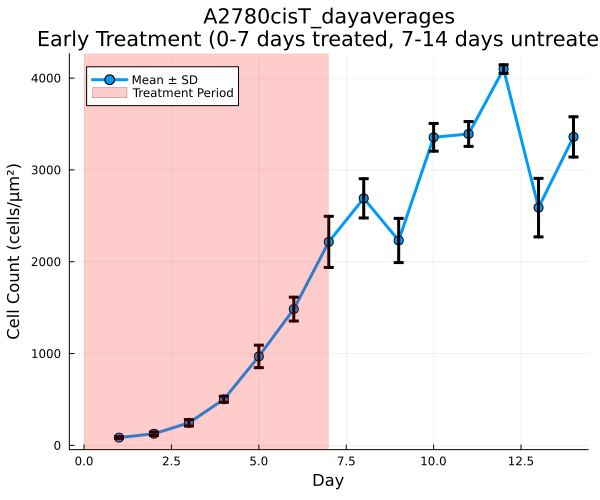


📊 Processing: A2780T_dayaverages.csv
   → Data range: Day 1.0-14.0, Cell count 164.70011574074073-2859.6863425925926
   → Treatment type: Early Treatment (0-7 days treated, 7-14 days untreated)


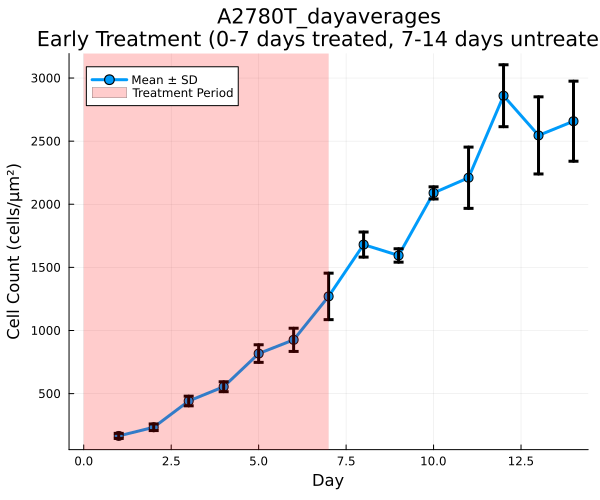


📊 Processing: A2780cisUT_dayaverages.csv
   → Data range: Day 1.0-14.0, Cell count 43.80231481481482-3813.640779320988
   → Treatment type: Late Treatment (0-7 days untreated, 7-14 days treated)


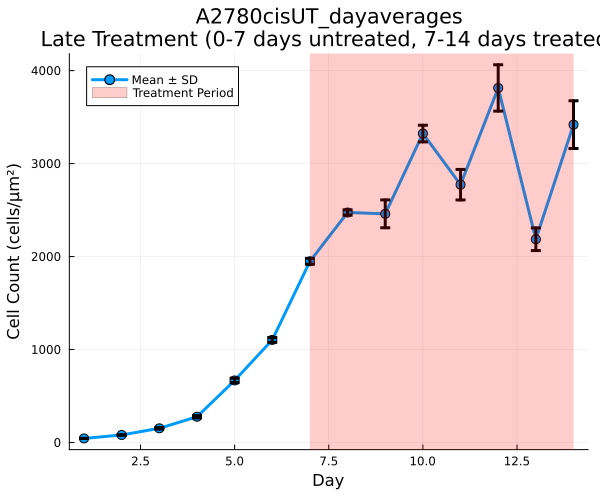


📊 Processing: A2780UT_dayaverages.csv
   → Data range: Day 1.0-14.0, Cell count 70.98599537037036-3088.9737268518525
   → Treatment type: Late Treatment (0-7 days untreated, 7-14 days treated)


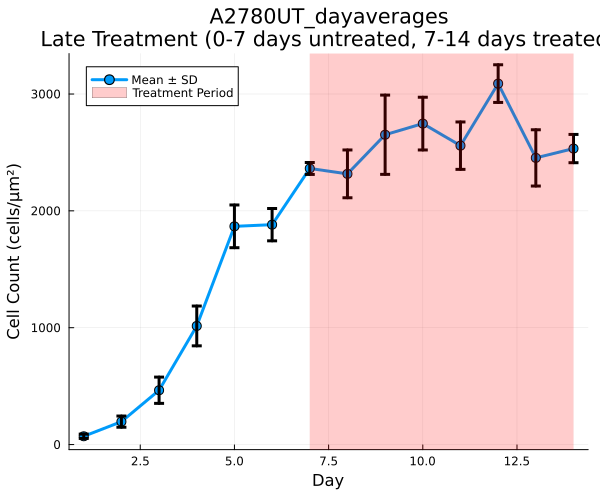


📈 Displaying combined overview for 20k seeding density...


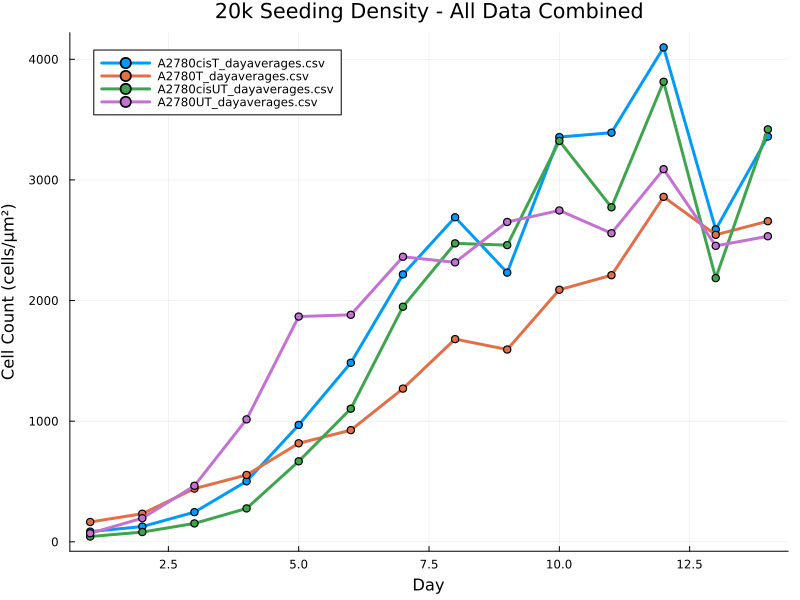


📊 Displaying treatment-specific combined plots...


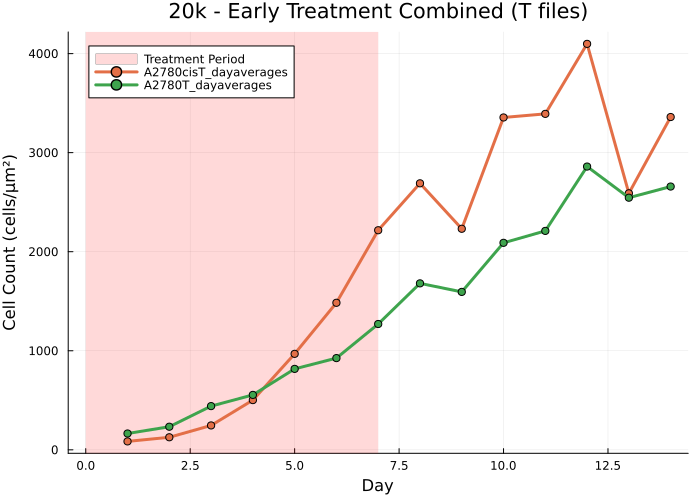

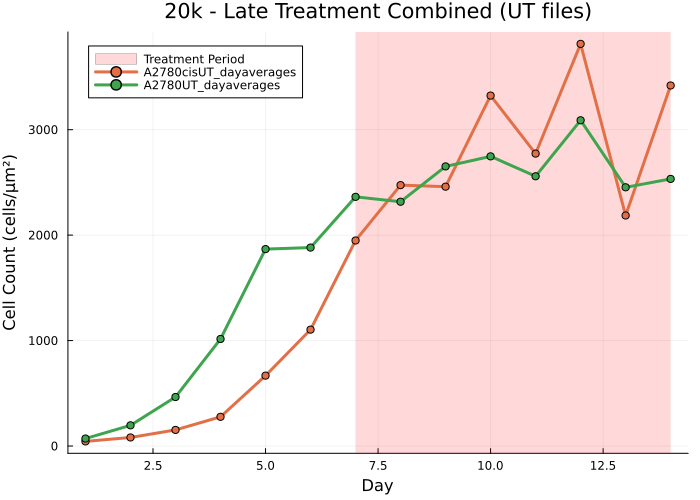

In [92]:
# Load and analyze 20k seeding density data
println("Loading 20k seeding density data...")
datasets_20k = load_intermittent_data("20k")

# Initialize storage for results
results_20k = Dict{String, Any}()
xy_data_20k = Dict{String, Tuple{Vector{Float64}, Vector{Float64}}}()

# Create combined overview plot
plot_all_combined = plot(title="20k Seeding Density - All Data Combined", xlabel="Day", ylabel="Cell Count (cells/μm²)", legend=:topleft, size=(800, 600))

# Process each dataset and create individual plots with error bars
for (filename, df) in datasets_20k
    println("\n📊 Processing: $filename")
    
    # Extract data including error information
    days = Float64.(df[:, 1])  # Day column
    mean_counts = Float64.(df[:, 2])  # Mean_Cells_um2 column
    std_devs = Float64.(df[:, 3])  # Std_Dev_um2 column
    
    # Store x,y data for later use
    xy_data_20k[filename] = (days, mean_counts)
    
    # Add to combined plot
    plot!(plot_all_combined, days, mean_counts, label=filename, lw=3, marker=:circle, markersize=4)
    
    # Create individual plot with error bars
    cell_type = replace(filename, ".csv" => "")
    treatment_info = if occursin("T_", filename) && !occursin("UT_", filename)
        "Early Treatment (0-7 days treated, 7-14 days untreated)"
    elseif occursin("UT_", filename)
        "Late Treatment (0-7 days untreated, 7-14 days treated)"
    else
        "Unknown treatment pattern"
    end
    
    individual_plot = plot(
        title="$cell_type\n$treatment_info",
        xlabel="Day", 
        ylabel="Cell Count (cells/μm²)",
        legend=:topleft,
        size=(600, 500)
    )
    
    # Plot with error bars (using standard deviation)
    plot!(individual_plot, days, mean_counts, 
          yerror=std_devs,
          label="Mean ± SD", 
          lw=3, 
          marker=:circle, 
          markersize=5,
          capsize=3)
    
    # Add treatment period indicators
    if occursin("T_", filename) && !occursin("UT_", filename)
        # Early treatment: shade 0-7 days
        vspan!(individual_plot, [0, 7], alpha=0.2, color=:red, label="Treatment Period")
    elseif occursin("UT_", filename)
        # Late treatment: shade 7-14 days
        vspan!(individual_plot, [7, 14], alpha=0.2, color=:red, label="Treatment Period")
    end
    
    println("   → Data range: Day $(days[1])-$(days[end]), Cell count $(minimum(mean_counts))-$(maximum(mean_counts))")
    println("   → Treatment type: $treatment_info")
    
    # Display individual plot
    display(individual_plot)
    
    # Store empty results since we're not doing model fitting
    results_20k[filename] = []
end

# Display combined overview plot
println("\n📈 Displaying combined overview for 20k seeding density...")
display(plot_all_combined)

# Create treatment-specific combined plots
plot_early_combined = plot(title="20k - Early Treatment Combined (T files)", xlabel="Day", ylabel="Cell Count (cells/μm²)", legend=:topleft, size=(700, 500))
plot_late_combined = plot(title="20k - Late Treatment Combined (UT files)", xlabel="Day", ylabel="Cell Count (cells/μm²)", legend=:topleft, size=(700, 500))

# Add treatment period shading
vspan!(plot_early_combined, [0, 7], alpha=0.15, color=:red, label="Treatment Period")
vspan!(plot_late_combined, [7, 14], alpha=0.15, color=:red, label="Treatment Period")

for (filename, df) in datasets_20k
    days = Float64.(df[:, 1])
    mean_counts = Float64.(df[:, 2])
    
    if occursin("T_", filename) && !occursin("UT_", filename)
        # Early treatment files
        plot!(plot_early_combined, days, mean_counts, 
              label=replace(filename, ".csv" => ""), 
              lw=3, marker=:circle, markersize=4)
    elseif occursin("UT_", filename)
        # Late treatment files  
        plot!(plot_late_combined, days, mean_counts, 
              label=replace(filename, ".csv" => ""), 
              lw=3, marker=:circle, markersize=4)
    end
end

println("\n📊 Displaying treatment-specific combined plots...")
display(plot_early_combined)
display(plot_late_combined)


Loading 30k seeding density data...
✅ Loaded: A2780T_dayaverages.csv (14 rows)
✅ Loaded: A2780UT_dayaverages.csv (14 rows)
✅ Loaded: A2780cisT_dayaverages.csv (14 rows)
✅ Loaded: A2780cisUT_dayaverages.csv (14 rows)

📊 Processing: A2780cisT_dayaverages.csv
   → Data range: Day 1.0-14.0, Cell count 107.89394290123457-4007.9396604938265
   → Treatment type: Early Treatment (0-7 days treated, 7-14 days untreated)


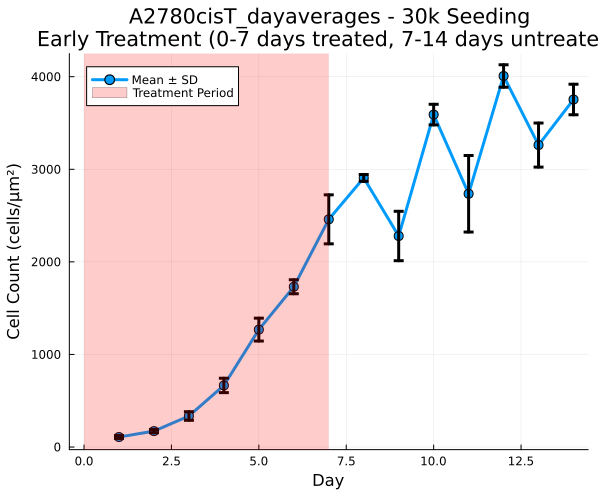


📊 Processing: A2780T_dayaverages.csv
   → Data range: Day 1.0-14.0, Cell count 288.98688271604937-2716.687654320988
   → Treatment type: Early Treatment (0-7 days treated, 7-14 days untreated)


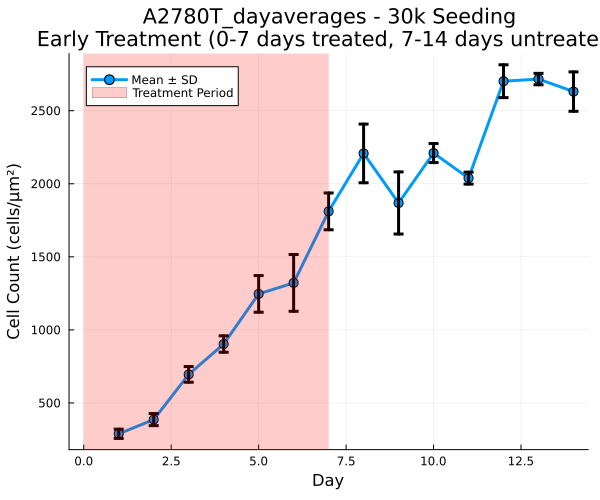


📊 Processing: A2780cisUT_dayaverages.csv
   → Data range: Day 1.0-14.0, Cell count 68.5091049382716-3735.9834104938273
   → Treatment type: Late Treatment (0-7 days untreated, 7-14 days treated)


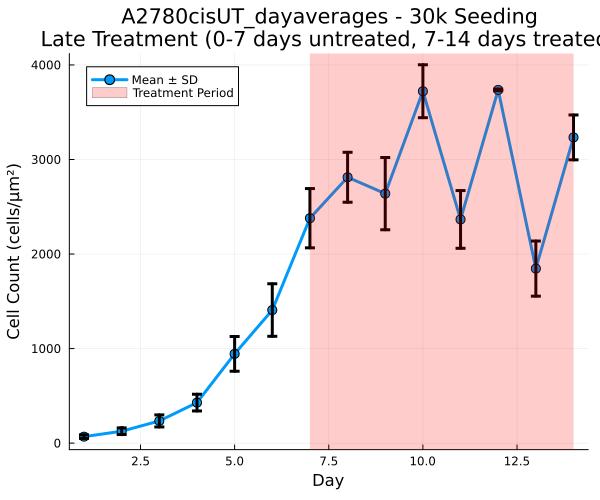


📊 Processing: A2780UT_dayaverages.csv
   → Data range: Day 1.0-14.0, Cell count 89.00717592592594-3023.571913580247
   → Treatment type: Late Treatment (0-7 days untreated, 7-14 days treated)


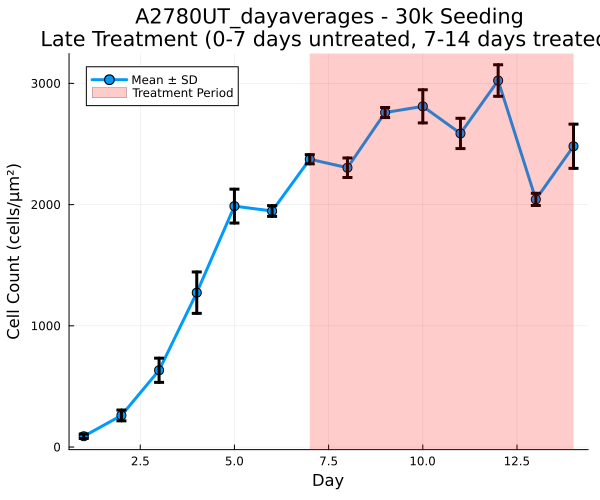


📈 Displaying combined overview for 30k seeding density...


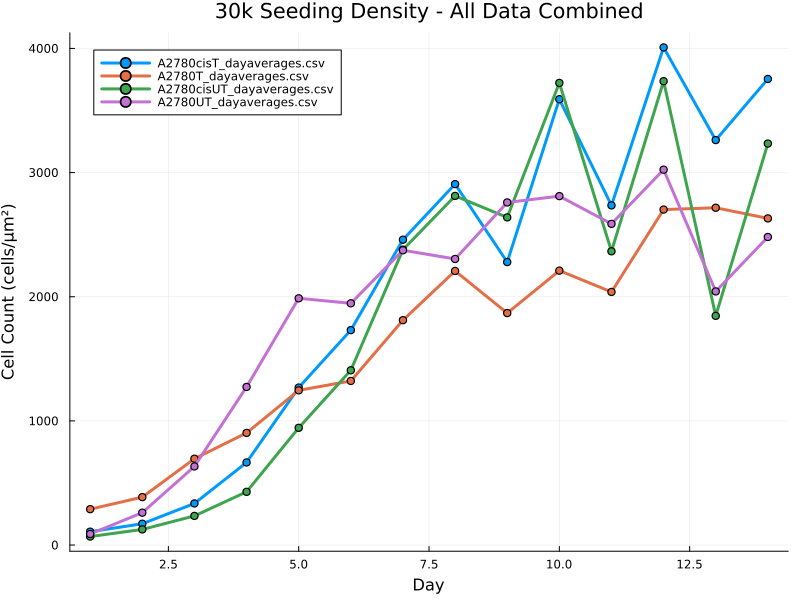


📊 Displaying treatment-specific combined plots...


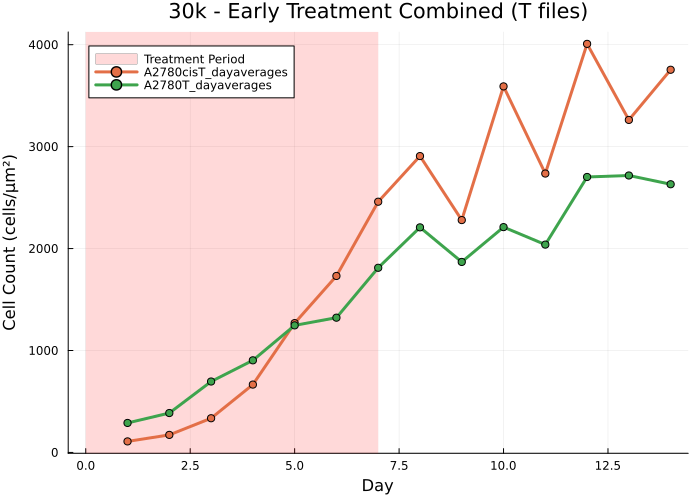

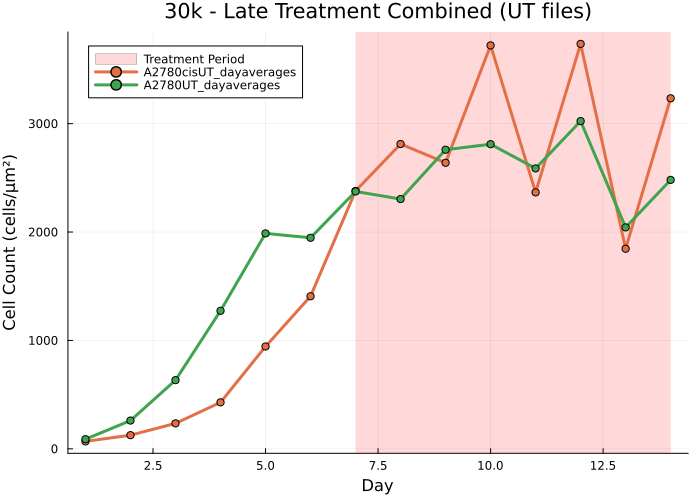

In [93]:
# Load and analyze 30k seeding density data
println("\nLoading 30k seeding density data...")
datasets_30k = load_intermittent_data("30k")

# Initialize storage for results
results_30k = Dict{String, Any}()
xy_data_30k = Dict{String, Tuple{Vector{Float64}, Vector{Float64}}}()

# Create combined overview plot
plot_all_combined_30k = plot(title="30k Seeding Density - All Data Combined", xlabel="Day", ylabel="Cell Count (cells/μm²)", legend=:topleft, size=(800, 600))

# Process each dataset and create individual plots with error bars
for (filename, df) in datasets_30k
    println("\n📊 Processing: $filename")
    
    # Extract data including error information
    days = Float64.(df[:, 1])  # Day column
    mean_counts = Float64.(df[:, 2])  # Mean_Cells_um2 column
    std_devs = Float64.(df[:, 3])  # Std_Dev_um2 column
    
    # Store x,y data for later use
    xy_data_30k[filename] = (days, mean_counts)
    
    # Add to combined plot
    plot!(plot_all_combined_30k, days, mean_counts, label=filename, lw=3, marker=:circle, markersize=4)
    
    # Create individual plot with error bars
    cell_type = replace(filename, ".csv" => "")
    treatment_info = if occursin("T_", filename) && !occursin("UT_", filename)
        "Early Treatment (0-7 days treated, 7-14 days untreated)"
    elseif occursin("UT_", filename)
        "Late Treatment (0-7 days untreated, 7-14 days treated)"
    else
        "Unknown treatment pattern"
    end
    
    individual_plot = plot(
        title="$cell_type - 30k Seeding\n$treatment_info",
        xlabel="Day", 
        ylabel="Cell Count (cells/μm²)",
        legend=:topleft,
        size=(600, 500)
    )
    
    # Plot with error bars (using standard deviation)
    plot!(individual_plot, days, mean_counts, 
          yerror=std_devs,
          label="Mean ± SD", 
          lw=3, 
          marker=:circle, 
          markersize=5,
          capsize=3)
    
    # Add treatment period indicators
    if occursin("T_", filename) && !occursin("UT_", filename)
        # Early treatment: shade 0-7 days
        vspan!(individual_plot, [0, 7], alpha=0.2, color=:red, label="Treatment Period")
    elseif occursin("UT_", filename)
        # Late treatment: shade 7-14 days
        vspan!(individual_plot, [7, 14], alpha=0.2, color=:red, label="Treatment Period")
    end
    
    println("   → Data range: Day $(days[1])-$(days[end]), Cell count $(minimum(mean_counts))-$(maximum(mean_counts))")
    println("   → Treatment type: $treatment_info")
    
    # Display individual plot
    display(individual_plot)
    
    # Store empty results since we're not doing model fitting
    results_30k[filename] = []
end

# Display combined overview plot
println("\n📈 Displaying combined overview for 30k seeding density...")
display(plot_all_combined_30k)

# Create treatment-specific combined plots
plot_early_combined_30k = plot(title="30k - Early Treatment Combined (T files)", xlabel="Day", ylabel="Cell Count (cells/μm²)", legend=:topleft, size=(700, 500))
plot_late_combined_30k = plot(title="30k - Late Treatment Combined (UT files)", xlabel="Day", ylabel="Cell Count (cells/μm²)", legend=:topleft, size=(700, 500))

# Add treatment period shading
vspan!(plot_early_combined_30k, [0, 7], alpha=0.15, color=:red, label="Treatment Period")
vspan!(plot_late_combined_30k, [7, 14], alpha=0.15, color=:red, label="Treatment Period")

for (filename, df) in datasets_30k
    days = Float64.(df[:, 1])
    mean_counts = Float64.(df[:, 2])
    
    if occursin("T_", filename) && !occursin("UT_", filename)
        # Early treatment files
        plot!(plot_early_combined_30k, days, mean_counts, 
              label=replace(filename, ".csv" => ""), 
              lw=3, marker=:circle, markersize=4)
    elseif occursin("UT_", filename)
        # Late treatment files  
        plot!(plot_late_combined_30k, days, mean_counts, 
              label=replace(filename, ".csv" => ""), 
              lw=3, marker=:circle, markersize=4)
    end
end

println("\n📊 Displaying treatment-specific combined plots...")
display(plot_early_combined_30k)
display(plot_late_combined_30k)

In [ ]:
# Helpers and single-fit utilities (appended at bottom)

# Alias logistic! if your models expect logistic! signature
const logistic! = logistic_growth!

# Wrapper to match signature expected in run_single_fit
function extract_day_averages_from_df(df::DataFrame)
    # Expect columns: Day, Mean, Std (or similar as earlier cells used indexing 1,2,3)
    x = Float64.(df[:, 1])
    y = Float64.(df[:, 2])
    return x, y
end

# Lightweight plotting/print wrapper consistent with earlier utilities
function pQuickStat(x, y, p̂, sol̂, prob̂, bic, ssr; title_str="Single fit result")
    println("Optimized Parameters: ", round.(p̂, digits=6))
    println("SSR: ", round(ssr, digits=6))
    println("BIC: ", round(bic, digits=3))
    p = plot(x, y, label="Data", lw=2, marker=:circle, xlabel="Day", ylabel="Cell Count", title=title_str)
    plot!(p, sol̂.t, [u[1] for u in sol̂.u], label="Model", lw=3, linestyle=:dash)
    display(p)
    return p
end

# Set up and optimize a single ODE model on one dataset (renamed to avoid clobbering earlier setUpProblem)
function fit_single_model(model, x, y, solver, u0, p0, tspan, bounds)
    prob = ODEProblem(model, u0, tspan, p0)
    solve(prob, solver, saveat=x, reltol=1e-12, abstol=1e-12) # warm solve
    loss = build_loss_objective(prob, solver, L2Loss(x, y), Optimization.AutoForwardDiff(); maxiters=10_000, verbose=false)
    result = bboptimize(loss; SearchRange=collect(zip(first.(bounds), last.(bounds))), Method=:de_rand_1_bin, MaxTime=60.0, TraceMode=:silent)
    p̂ = best_candidate(result)
    prob̂ = ODEProblem(model, [y[1]], tspan, p̂)
    x_dense = range(x[1], x[end], length=1000)
    sol̂ = solve(prob̂, solver, reltol=1e-12, abstol=1e-12, saveat=x_dense)
    return p̂, sol̂, prob̂
end

function run_single_fit(df::DataFrame, p0::Vector{<:Real}; cell_size=1.0, model=logistic!, fixed_params=nothing, solver=Rodas5(), bounds=nothing, show_stats::Bool=true)
    if fixed_params !== nothing
        old_model = model
        model = (du,u,p,t) -> old_model(du, u, vcat(p, fixed_params), t)
    end
    nparams = length(p0)
    bounds === nothing && (bounds = [(0.0, Inf) for _ in 1:nparams])
    x, y = extract_day_averages_from_df(df)
    tspan = (x[1], x[end])
    u0 = [y[1]]
    p̂, sol̂, prob̂ = fit_single_model(model, x, y, solver, u0, p0, tspan, bounds)
    bic, ssr = calculate_bic(prob̂, x, y, solver, p̂)
    show_stats && pQuickStat(x, y, p̂, sol̂, prob̂, bic, ssr)
    return (params=p̂, bic=bic, ssr=ssr, sol=sol̂)
end

run_single_fit (generic function with 1 method)

Using dataset: A2780cisT_dayaverages.csv
Optimized Parameters: [0.684197, 3376.07007]
SSR: 1.773114927548e6
BIC: 169.767
Optimized Parameters: [0.684197, 3376.07007]
SSR: 1.773114927548e6
BIC: 169.767


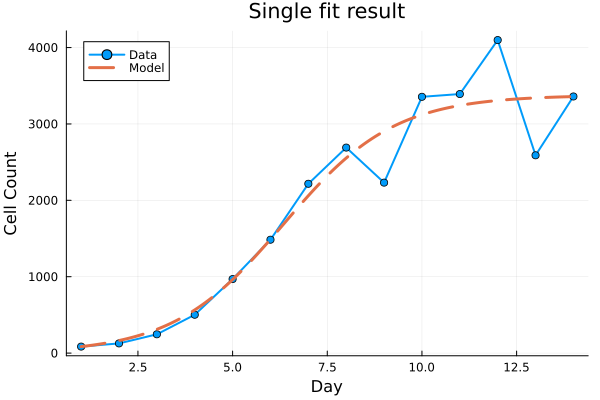


Chosen params: [0.6841974290150803, 3376.0700699991344]


In [95]:
# Demo: run a single fit on one 20k dataset

# Assumes datasets_20k from earlier cell is available. If not, re-load here:
if !@isdefined(datasets_20k)
    println("Reloading 20k datasets...")
    datasets_20k = load_intermittent_data("20k")
end

# Pick one file – choose a treated early group (T_) for demonstration if available
chosen_name = nothing
for (fname, _) in datasets_20k
    if occursin("T_", fname) && !occursin("UT_", fname)
        chosen_name = fname
        break
    end
end
chosen_name === nothing && (chosen_name = first(keys(datasets_20k)))
println("Using dataset: ", chosen_name)

df = datasets_20k[chosen_name]

# Initial parameter guess and bounds for logistic growth: p = [r, K]
p0 = [0.5, maximum(Float64.(df[:,2])) * 2]
bounds = [(0.0, 5.0), (1.0, maximum(Float64.(df[:,2])) * 10)]

fit = run_single_fit(df, p0; cell_size=1.0, model=logistic!, fixed_params=nothing, solver=Rodas5(), bounds=bounds, show_stats=true)

println("\nChosen params: ", fit.params)


## A2780cisT: early-treatment model fits with error bars

This section fits the A2780cisT_dayaverages.csv dataset using the early-treatment models with the existing `run_single_fit` utility and overlays model predictions on the data with mean ± SD error bars.

Models compared:
- Early treatment with lingering exponential decay (`early_treatment_decay!`)
- Early treatment with biphasic decay (`early_treatment_biphasic!`)
- Early treatment with power-law decay (`early_treatment_powerlaw!`)
- Early treatment with Hill-effect buildup during treatment (`early_treatment_hill!`)

Notes:
- If `datasets_20k` is not already in memory, it will be loaded.
- Parameter bounds are kept broad but physically reasonable (e.g., nonnegative growth, 0–1 drug effect).
- We suppress internal plots from `run_single_fit` and instead render one combined plot with error bars and all model trajectories.

Best model by BIC: Exp decay
Params: [1.4982220873968641, 3351.6967427185314, 0.5439375084355494, 19.99999999999892]
BIC: 175.01548557160763, SSR: 1.7693929187894645e6

Model summary (BIC, SSR, params):
Exp decay   BIC=   175.015  SSR=1769392.9188  params=[1.4982, 3351.6967, 0.5439, 20.0]
Biphasic    BIC=   180.291  SSR=1769094.4969  params=[1.9329, 3350.7358, 0.6465, 9.3984, 30.0, 0.0]
Power-law   BIC=   176.888  SSR=1675132.2372  params=[5.0, 3327.2549, 0.8641, 5.0, 3.7537]
Hill        BIC=   177.684  SSR=1773114.9273  params=[0.6842, 3376.0712, 0.0, 4.6577, 5.9007]


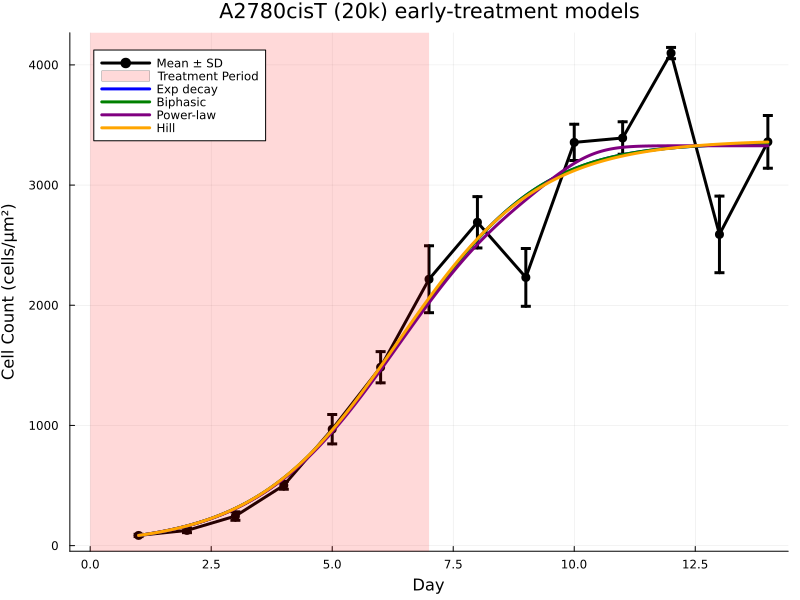

In [97]:
# Fit A2780cisT_dayaverages.csv with early-treatment models and plot with error bars

# Ensure 20k datasets are loaded
if !@isdefined(datasets_20k)
    println("Reloading 20k datasets...")
    datasets_20k = load_intermittent_data("20k")
end

fname = "A2780cisT_dayaverages.csv"
@assert haskey(datasets_20k, fname) "Dataset $(fname) not found. Check the processed data path."

df = datasets_20k[fname]

# Extract x (days), y (mean), and std for error bars (assuming columns: Day, Mean, Std)
days = Float64.(df[:, 1])
means = Float64.(df[:, 2])
stds = Float64.(df[:, 3])

# Convenience: turn off internal plotting; we'll do a single combined plot here
show_stats = false

# Common setup
solver = Rodas5()
K_guess = maximum(means) * 2
r_guess = 0.5

# Base bounds helpers
K_max = max(K_guess * 10, maximum(means) * 10)
r_bounds = (0.0, 5.0)
K_bounds = (1.0, K_max)

# 1) Early treatment with lingering exponential decay: p = [r, K, drug_effect, decay_rate]
p0_decay = [r_guess, K_guess, 0.4, 3.0]
bounds_decay = [r_bounds, K_bounds, (0.0, 1.0), (0.1, 20.0)]
fit_decay = run_single_fit(df, p0_decay; model=early_treatment_decay!, solver=solver, bounds=bounds_decay, show_stats=show_stats)

# 2) Early treatment biphasic: p = [r, K, drug_effect, fast_decay, slow_decay, fast_fraction]
p0_bi = [r_guess, K_guess, 0.4, 1.5, 8.0, 0.6]
bounds_bi = [r_bounds, K_bounds, (0.0, 1.0), (0.1, 10.0), (0.5, 30.0), (0.0, 1.0)]
fit_bi = run_single_fit(df, p0_bi; model=early_treatment_biphasic!, solver=solver, bounds=bounds_bi, show_stats=show_stats)

# 3) Early treatment power-law: p = [r, K, drug_effect, decay_exponent, time_scale]
p0_pl = [r_guess, K_guess, 0.4, 1.2, 4.0]
bounds_pl = [r_bounds, K_bounds, (0.0, 1.0), (0.2, 5.0), (0.2, 30.0)]
fit_pl = run_single_fit(df, p0_pl; model=early_treatment_powerlaw!, solver=solver, bounds=bounds_pl, show_stats=show_stats)

# 4) Early treatment Hill effect: p = [r, K, max_drug_effect, hill_coeff, half_effect_time]
p0_hill = [r_guess, K_guess, 0.6, 2.0, 3.5]
bounds_hill = [r_bounds, K_bounds, (0.0, 1.0), (0.5, 5.0), (0.1, 7.0)]
fit_hill = run_single_fit(df, p0_hill; model=early_treatment_hill!, solver=solver, bounds=bounds_hill, show_stats=show_stats)

# Collect fits in a fixed order for consistent plotting
fits = Dict(
    "Exp decay" => fit_decay,
    "Biphasic" => fit_bi,
    "Power-law" => fit_pl,
    "Hill" => fit_hill,
)
labels = ["Exp decay", "Biphasic", "Power-law", "Hill"]

# Determine the best model by BIC among the selected labels
bics = [fits[l].bic for l in labels]
min_bic, min_idx = findmin(bics)
best_name = labels[min_idx]
best_fit = fits[best_name]
println("Best model by BIC: ", best_name)
println("Params: ", best_fit.params)
println("BIC: ", best_fit.bic, ", SSR: ", best_fit.ssr)

# Also print a compact summary for all models
println("\nModel summary (BIC, SSR, params):")
for l in labels
    f = fits[l]
    @printf("%-10s  BIC=%10.3f  SSR=%10.4f  params=%s\n", l, f.bic, f.ssr, string(round.(f.params, digits=4)))
end

# Plot: data with error bars + all model curves
p = plot(title = "A2780cisT (20k) early-treatment models",
         xlabel = "Day", ylabel = "Cell Count (cells/μm²)",
         legend = :topleft, size=(800, 600))

# Data with error bars
plot!(p, days, means; yerror=stds, label="Mean ± SD", lw=3, marker=:circle, markersize=5, capsize=3, color=:black)

# Shade treatment period 0-7 days
vspan!(p, [0, 7], alpha=0.15, color=:red, label="Treatment Period")

# Overlay model trajectories
colors = [:blue, :green, :purple, :orange]
for (i, lbl) in enumerate(labels)
    sol = fits[lbl].sol
    plot!(p, sol.t, [u[1] for u in sol.u]; label=lbl, lw=3, color=colors[i])
end

display(p)

## Batch analysis: fit all 20k datasets

This section iterates over all 20k day-averaged CSVs, selects model families by treatment timing, runs `run_single_fit` for each model, plots the data with mean ± SD error bars, overlays all model trajectories, prints a compact summary (BIC, SSR, params), and collects a results table.


Processing: A2780T_dayaverages.csv
Model summary (BIC, SSR, params):
  Biphasic        BIC=   153.111  SSR=253863.4533  params=[1.2095, 2801.7623, 0.6516, 9.0413, 30.0, 0.0]
  Exp decay       BIC=   147.846  SSR=254094.0413  params=[0.9565, 2803.0122, 0.5597, 20.0]
  Hill            BIC=   150.793  SSR=259742.6215  params=[0.4578, 2885.714, 0.2453, 4.5651, 4.7944]
  Power-law       BIC=   146.715  SSR=194107.8352  params=[5.0, 2658.2961, 0.9141, 5.0, 5.5431]


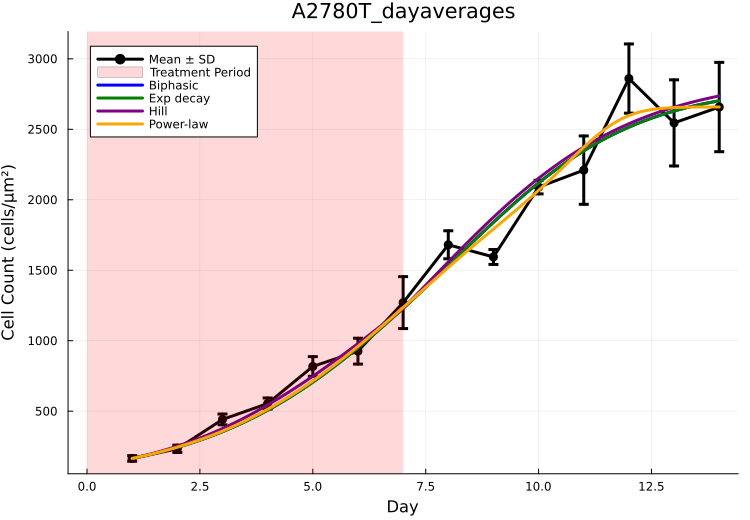


Processing: A2780UT_dayaverages.csv
Model summary (BIC, SSR, params):
  Late Hill       BIC=   159.030  SSR=467815.9935  params=[1.0224, 2625.4008, 0.2405, 5.0, 0.1722]
  Late buildup    BIC=   156.369  SSR=467075.0444  params=[1.0195, 2625.0867, 0.2102, 0.1]
  Late immediate  BIC=   153.713  SSR=466517.2604  params=[1.0195, 2625.2123, 0.2143]


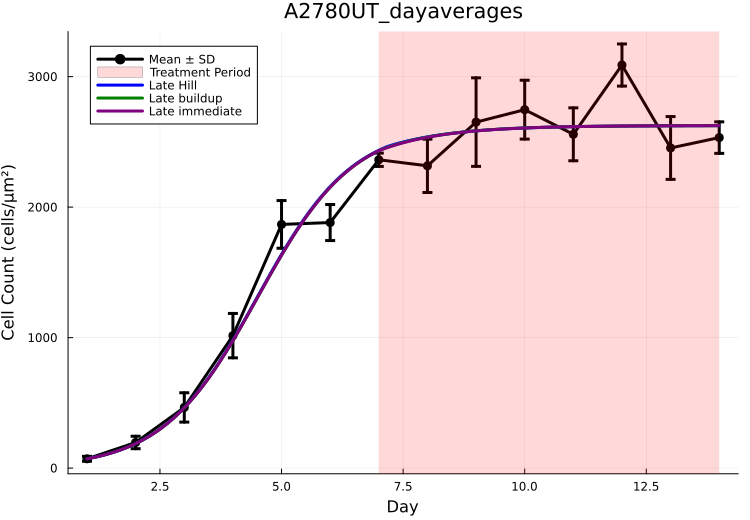


Processing: A2780cisT_dayaverages.csv
Model summary (BIC, SSR, params):
  Biphasic        BIC=   180.291  SSR=1769094.4971  params=[1.9329, 3350.736, 0.6465, 1.7426, 30.0, 0.0]
  Exp decay       BIC=   175.015  SSR=1769392.9188  params=[1.4982, 3351.6967, 0.5439, 20.0]
  Hill            BIC=   177.684  SSR=1773114.9275  params=[0.6842, 3376.0701, 0.0, 0.7616, 2.5852]
  Power-law       BIC=   176.888  SSR=1675132.2383  params=[5.0, 3327.2549, 0.8641, 5.0, 3.7537]


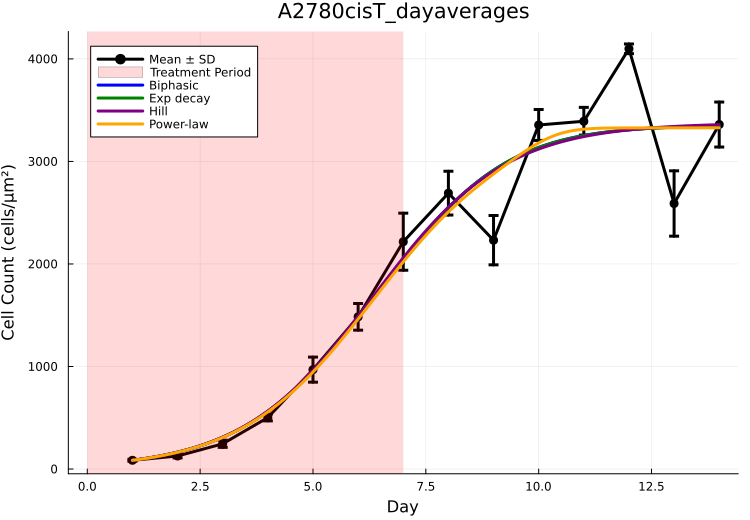


Processing: A2780cisUT_dayaverages.csv
Model summary (BIC, SSR, params):
  Late Hill       BIC=   177.959  SSR=1808246.0400  params=[0.7512, 3293.2196, 1.0, 5.0, 3.2425]
  Late buildup    BIC=   175.473  SSR=1828165.0637  params=[0.7659, 3148.3158, 0.0, 0.8332]
  Late immediate  BIC=   172.834  SSR=1828165.0669  params=[0.7659, 3148.3144, 0.0]


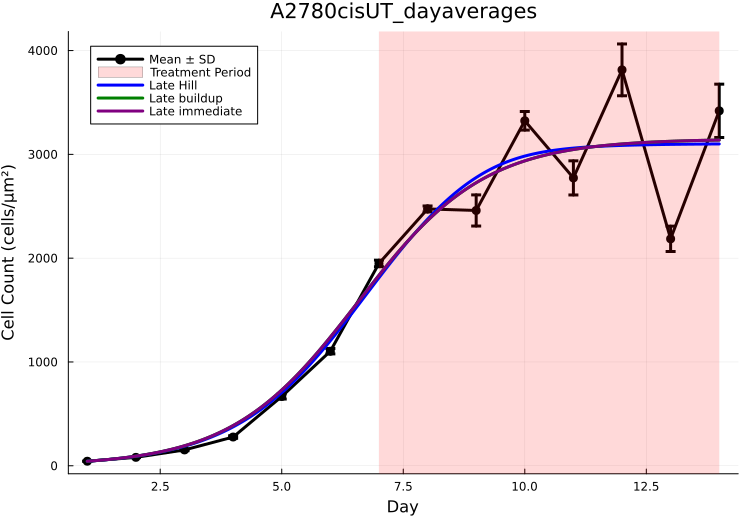


All 20k files processed. Summary table (first few rows):


10×5 DataFrame
 Row │ filename                   model           bic      ssr             par ⋯
     │ String                     String          Float64  Float64         Str ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ A2780T_dayaverages.csv     Biphasic        153.111       2.53863e5  [1. ⋯
   2 │ A2780T_dayaverages.csv     Exp decay       147.846  254094.0        [0.
   3 │ A2780T_dayaverages.csv     Hill            150.793       2.59743e5  [0.
   4 │ A2780T_dayaverages.csv     Power-law       146.715       1.94108e5  [5.
   5 │ A2780UT_dayaverages.csv    Late Hill       159.03   467816.0        [1. ⋯
   6 │ A2780UT_dayaverages.csv    Late buildup    156.369  467075.0        [1.
   7 │ A2780UT_dayaverages.csv    Late immediate  153.713       4.66517e5  [1.
   8 │ A2780cisT_dayaverages.csv  Biphasic        180.291       1.76909e6  [1.
   9 │ A2780cisT_dayaverages.csv  Exp decay       175.015       1.76939e6  [1. ⋯
  10 │ A2780cisT_dayaverages.csv  Hill            177.684       1.77311e6  [0.
                                                                1 column omitted

In [98]:
# Batch fit for all 20k datasets (early vs late models) with error bars and summary table

# Ensure 20k datasets are available
if !@isdefined(datasets_20k)
    println("Reloading 20k datasets...")
    datasets_20k = load_intermittent_data("20k")
end

# Prepare a results DataFrame to collect summaries
results_cols = [:filename, :model, :bic, :ssr, :params]
results_types = [String, String, Float64, Float64, String]
results_df = DataFrame(; (Symbol(c)=>Vector{T}() for (c,T) in zip(results_cols, results_types))...)

# Iterate deterministically by sorted filenames for reproducibility
for filename in sort(collect(keys(datasets_20k)))
    df = datasets_20k[filename]
    println("\n==============================")
    println("Processing: ", filename)

    # Extract columns: Day, Mean, Std
    days = Float64.(df[:,1])
    means = Float64.(df[:,2])
    stds = Float64.(df[:,3])

    # Decide early vs late models based on filename pattern
    is_early = occursin("T_", filename) && !occursin("UT_", filename)
    is_late  = occursin("UT_", filename)

    # Common setup
    solver = Rodas5()
    K_guess = maximum(means) * 2
    r_guess = 0.5
    K_max = max(K_guess * 10, maximum(means) * 10)
    r_bounds = (0.0, 5.0)
    K_bounds = (1.0, K_max)

    # Define model sets and their p0/bounds depending on early/late
    fits = Dict{String, Any}()

    if is_early
        # Early-treatment models
        p0_decay = [r_guess, K_guess, 0.4, 3.0]
        bounds_decay = [r_bounds, K_bounds, (0.0, 1.0), (0.1, 20.0)]
        fits["Exp decay"] = run_single_fit(df, p0_decay; model=early_treatment_decay!, solver=solver, bounds=bounds_decay, show_stats=false)

        p0_bi = [r_guess, K_guess, 0.4, 1.5, 8.0, 0.6]
        bounds_bi = [r_bounds, K_bounds, (0.0, 1.0), (0.1, 10.0), (0.5, 30.0), (0.0, 1.0)]
        fits["Biphasic"] = run_single_fit(df, p0_bi; model=early_treatment_biphasic!, solver=solver, bounds=bounds_bi, show_stats=false)

        p0_pl = [r_guess, K_guess, 0.4, 1.2, 4.0]
        bounds_pl = [r_bounds, K_bounds, (0.0, 1.0), (0.2, 5.0), (0.2, 30.0)]
        fits["Power-law"] = run_single_fit(df, p0_pl; model=early_treatment_powerlaw!, solver=solver, bounds=bounds_pl, show_stats=false)

        p0_hill = [r_guess, K_guess, 0.6, 2.0, 3.5]
        bounds_hill = [r_bounds, K_bounds, (0.0, 1.0), (0.5, 5.0), (0.1, 7.0)]
        fits["Hill"] = run_single_fit(df, p0_hill; model=early_treatment_hill!, solver=solver, bounds=bounds_hill, show_stats=false)
    elseif is_late
        # Late-treatment models
        # 1) Immediate effect during 7-14: late_treatment!
        p0_late = [r_guess, K_guess, 0.4]
        bounds_late = [r_bounds, K_bounds, (0.0, 1.0)]
        fits["Late immediate"] = run_single_fit(df, p0_late; model=late_treatment!, solver=solver, bounds=bounds_late, show_stats=false)

        # 2) Buildup effect during 7-14: late_treatment_buildup!
        p0_bu = [r_guess, K_guess, 0.6, 2.0]
        bounds_bu = [r_bounds, K_bounds, (0.0, 1.0), (0.1, 10.0)]
        fits["Late buildup"] = run_single_fit(df, p0_bu; model=late_treatment_buildup!, solver=solver, bounds=bounds_bu, show_stats=false)

        # 3) Hill effect during 7-14: late_treatment_hill!
        p0_lhill = [r_guess, K_guess, 0.6, 2.0, 3.5]
        bounds_lhill = [r_bounds, K_bounds, (0.0, 1.0), (0.5, 5.0), (0.1, 7.0)]
        fits["Late Hill"] = run_single_fit(df, p0_lhill; model=late_treatment_hill!, solver=solver, bounds=bounds_lhill, show_stats=false)
    else
        # If we cannot decide, fall back to logistic-only as a minimal baseline
        p0_log = [r_guess, K_guess]
        bounds_log = [r_bounds, K_bounds]
        fits["Logistic"] = run_single_fit(df, p0_log; model=logistic!, solver=solver, bounds=bounds_log, show_stats=false)
    end

    # Prepare plot for this file
    title_str = string(replace(filename, ".csv" => ""))
    p = plot(title=title_str, xlabel="Day", ylabel="Cell Count (cells/μm²)", legend=:topleft, size=(750, 520))
    plot!(p, days, means; yerror=stds, label="Mean ± SD", lw=3, marker=:circle, markersize=5, capsize=3, color=:black)

    # Shade treatment periods
    if is_early
        vspan!(p, [0, 7], alpha=0.15, color=:red, label="Treatment Period")
    elseif is_late
        vspan!(p, [7, 14], alpha=0.15, color=:red, label="Treatment Period")
    end

    # Order labels for consistent coloring
    labels = collect(keys(fits))
    sort!(labels)
    palette = [:blue, :green, :purple, :orange, :teal, :magenta]

    println("Model summary (BIC, SSR, params):")
    for (i, lbl) in enumerate(labels)
        f = fits[lbl]
        # Print line summary
        @printf("  %-14s  BIC=%10.3f  SSR=%10.4f  params=%s\n", lbl, f.bic, f.ssr, string(round.(f.params, digits=4)))
        # Add to results table
        push!(results_df, (filename, lbl, f.bic, f.ssr, string(round.(f.params, digits=6))))
        # Plot
        sol = f.sol
        plot!(p, sol.t, [u[1] for u in sol.u]; label=lbl, lw=3, color=palette[1 + (i-1) % length(palette)])
    end

    display(p)
end

println("\nAll 20k files processed. Summary table (first few rows):")
first(results_df, 10)